In [1]:
from sklearn.decomposition import PCA
from model.TransE import *
from model.ConvKB import ConvKB
from model.utils import *
from model.CustomTripletMarginLoss import CustomTripletMarginLoss
from argparse import Namespace
import torch
import torch.nn as nn
import sys
from torch.autograd import Variable
import torch.optim as optim
from numpy import linalg as LA
import numpy as np
from math import log10,floor
import json
import pickle
from sklearn.cluster import KMeans,MeanShift,SpectralClustering
from sklearn import mixture
from collections import Counter
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
# from ggplot import *
from model.CapsuleNet import *

In [2]:
START_CLUSTER = 1
END_CLUSTER = 425
WEIGHT_PATH = "/storage/quandh/OsGenePrio_capse/data/capse_3_param2/param2/CapsE.pkl"
DEVICE = 2 

In [6]:
#LOAD VECTOR OF GENE
# if torch.cuda.is_available():
#     net = torch.load("./data/GENE/ConvKB.pkl")
# else:
#     net = torch.load("./data/GENE/ConvKB.pkl", map_location=lambda storage, loc: storage)
# net = list(net.items())
# data_train = net[0][1].cpu().numpy()

#Load data to show attributes of gene
with open("./support/uniprot.pkl","rb") as f:
    uniprot = pickle.load(f)
    f.close()
with open("./support/pyrice.pkl","rb") as f:
    pyrice = pickle.load(f)
    f.close()
with open("./support/id_dict_2018", "rb") as f:
    id_dict_2018 = pickle.load(f)
    f.close()
with open("./support/loc_dict_2018", "rb") as f:
    loc_dict_2018 = pickle.load(f)
    f.close()
entity_total = get_total("./data/GENE/entity2id.txt")
relation_total = get_total("./data/GENE/relation2id.txt")
processed_entity_2_id = load_data("./data/GENE/entity2id.txt", ignore_first=True)
relation_2_id = load_data("./data/GENE/relation2id.txt", ignore_first=True)
triple_list = []
processed_id_2_entity = dict()
i = 0
with open("./data/GENE/entity2id.txt", 'r') as f:
    for line in f:
        if True and i == 0:
            i += 1
            continue
        line = line.strip()
        if line == '':
            continue
        parts = line.split("\t")
        processed_id_2_entity[int(parts[1])] = parts[0]
i = 0
triple_list =[]
with open("./data/GENE/triplet2id.txt", 'r') as f:
    for line in f:
        if True and i == 0:
            i += 1
            continue
        line = line.strip()
        if line == '':
            continue
        parts = line.split("\t")
        head = int(parts[0])
        tail = int(parts[1])
        rel = int(parts[2])
        triple_list.append((head,tail,rel))
        
net = CapsuleNetwork(entity_total = entity_total, relation_total = relation_total, embedding_size =150, vec_len_secondCaps = 10, 
                     num_units = 1, num_iterations = 3, num_filters = 150)
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(DEVICE) if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(WEIGHT_PATH, map_location = device)
    net.to(device)
else:
    checkpoint = torch.load(WEIGHT_PATH, map_location=lambda storage, loc: storage)
net.load_state_dict(checkpoint)
net.eval()
embedding_items = list(checkpoint.items())
data_train = embedding_items[0][1].cpu().numpy()

# net = CapsuleNetwork(entity_total = entity_total, relation_total = relation_total, embedding_size =150, vec_len_secondCaps = 10, 
#                      num_units = 1, num_iterations = 3, num_filters = 150)
# checkpoint = torch.load("/storage/quandh/OsGenePrio_capse/data/capse_3_param2/param2/CapsE.pkl", map_location=lambda storage, loc: storage)
# net.load_state_dict(checkpoint)

In [ ]:
#RUN WITH ALL GENE
get_index_gene = []
for gene_name in id_dict_2018.keys():
    if gene_name in processed_entity_2_id.keys():
        get_index_gene.append(processed_entity_2_id[gene_name])          

In [ ]:
#RUN KMEANS
X = data_train[get_index_gene]
loss_kmeans = [] 
loss = 10000
for cluster in range(START_CLUSTER, END_CLUSTER):
    kmeans = KMeans(n_clusters=cluster, random_state=0).fit(X)
    loss_kmean = kmeans.inertia_
    print("Loss {} : {}".format(cluster,loss_kmean))
    loss_kmeans.append(loss_kmean)
    if loss_kmean < loss:
        loss = loss_kmean
        Y = kmeans.labels_

Loss 1 : 3069417.5
Loss 2 : 2396792.1016134424
Loss 3 : 2188106.3199844738
Loss 4 : 2117054.331154583
Loss 5 : 2062242.6934835413
Loss 6 : 2011436.6112875105
Loss 7 : 1977998.701847293
Loss 8 : 1949101.75850247
Loss 9 : 1925986.5314525783
Loss 10 : 1904323.321199119
Loss 11 : 1885167.7902902903
Loss 12 : 1867900.1777149285
Loss 13 : 1852157.896983217
Loss 14 : 1838692.978270715
Loss 15 : 1822974.2451826942
Loss 16 : 1810741.269690424
Loss 17 : 1800609.6429619736
Loss 18 : 1789692.2547910905
Loss 19 : 1780490.227657947
Loss 20 : 1771249.4807514863
Loss 21 : 1762901.3578548972
Loss 22 : 1755500.7141479673
Loss 23 : 1748654.327339815
Loss 24 : 1742186.9730533573
Loss 25 : 1734782.356252366
Loss 26 : 1728991.3816017401
Loss 27 : 1722743.165127428
Loss 28 : 1717433.105563836
Loss 29 : 1712058.7914035066
Loss 30 : 1708142.0858802432
Loss 31 : 1703731.6948488723
Loss 32 : 1699400.485080751
Loss 33 : 1694611.144546835
Loss 34 : 1690044.6165819499
Loss 35 : 1685268.0761305564
Loss 36 : 1680521.

In [25]:
loss_kmeans

[3069417.5,
 2396792.1016134424,
 2188106.3199844738,
 2117054.331154583,
 2062242.6934835413,
 2011436.6112875105,
 1977998.701847293,
 1949101.75850247,
 1925986.5314525783,
 1904323.321199119,
 1885167.7902902903,
 1867900.1777149285,
 1852157.896983217,
 1838692.978270715,
 1822974.2451826942,
 1810741.269690424,
 1800609.6429619736,
 1789692.2547910905,
 1780490.227657947,
 1771249.4807514863,
 1762901.3578548972,
 1755500.7141479673,
 1748654.327339815,
 1742186.9730533573,
 1734782.356252366,
 1728991.3816017401,
 1722743.165127428,
 1717433.105563836,
 1712058.7914035066,
 1708142.0858802432,
 1703731.6948488723,
 1699400.485080751,
 1694611.144546835,
 1690044.6165819499,
 1685268.0761305564,
 1680521.0266625371,
 1677835.0623674577,
 1673788.6508597785,
 1670443.8703138544,
 1666846.7367322638,
 1663372.2316545192,
 1659582.2864289545,
 1656172.689225992,
 1652731.0770769215,
 1649936.9790638785,
 1646557.8689218294,
 1643207.4521122891,
 1640851.9294300233,
 1637660.58200910

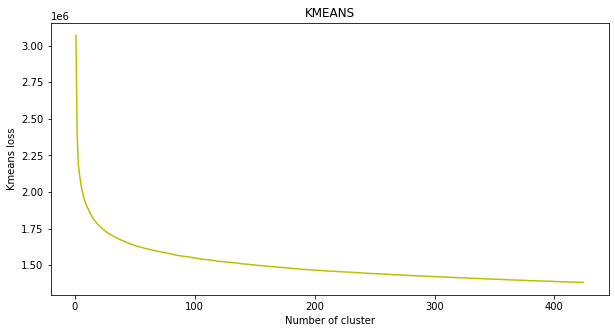

In [9]:
#VISUALIZE LOSS WITH CLUSTER KMEANS
plt.figure(figsize=[10, 5])
plt.plot(range(1,len(loss_kmeans)+1),loss_kmeans,'y-')
plt.title('KMEANS')
plt.xlabel('Number of cluster')
plt.ylabel('Kmeans loss')
plt.show()

In [20]:
#Run again KMeans
kmeans = KMeans(n_clusters=100, random_state=0).fit(X)
loss_kmean = kmeans.inertia_
# print("Loss {} : {}".format(cluster,loss_kmean))
Y = kmeans.labels_

In [21]:
#PREPARE DATA FOR VISUALIZER
feat_cols = ['number'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = Y
df['label'] = df['label'].apply(lambda i: str(i))

print ('Size of the dataframe: {}'.format(df.shape))
rndperm = np.random.permutation(df.shape[0])

#COUNT NUMBER GENE IN EACH CLUSTER
counter = Counter(Y)
counter = dict(counter)
print(counter)

#VISUALIZER NUMBER GENE
NUMBER_GENE = 100 #NUMBER GENE IN CLUSTER
new_dict = dict()
list_index = []
for i in range(len(counter)):
    new_dict.setdefault(i,0)
for i in rndperm[:len(Y)]:
    if new_dict[Y[i]] > NUMBER_GENE:
        continue
    else:
        new_dict[Y[i]]+=1
        list_index.append(i)

Size of the dataframe: (31415, 151)
{88: 221, 54: 193, 99: 169, 17: 655, 9: 775, 60: 516, 90: 118, 39: 352, 71: 403, 59: 342, 76: 397, 5: 277, 74: 411, 37: 411, 46: 229, 14: 282, 16: 260, 81: 306, 6: 301, 51: 506, 25: 247, 89: 222, 34: 259, 42: 370, 21: 283, 10: 1194, 96: 270, 73: 473, 8: 241, 87: 233, 58: 160, 24: 185, 75: 117, 11: 212, 28: 272, 79: 1376, 27: 284, 44: 1428, 47: 387, 20: 182, 49: 192, 15: 1018, 41: 273, 32: 238, 45: 200, 94: 171, 97: 462, 12: 311, 0: 224, 35: 1246, 43: 84, 13: 532, 3: 503, 93: 198, 50: 379, 70: 483, 66: 93, 53: 168, 86: 343, 62: 317, 91: 280, 55: 189, 18: 214, 72: 305, 77: 134, 26: 477, 22: 230, 33: 428, 40: 235, 92: 147, 52: 391, 84: 346, 98: 363, 61: 328, 36: 144, 56: 139, 1: 576, 68: 120, 63: 143, 2: 400, 64: 82, 65: 127, 29: 234, 38: 63, 85: 95, 19: 87, 4: 161, 30: 120, 31: 145, 48: 112, 80: 147, 83: 235, 7: 191, 67: 263, 82: 122, 23: 296, 69: 187, 95: 63, 57: 65, 78: 77}


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Explained variation per principal component: [0.31165445 0.04379377 0.03484149]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

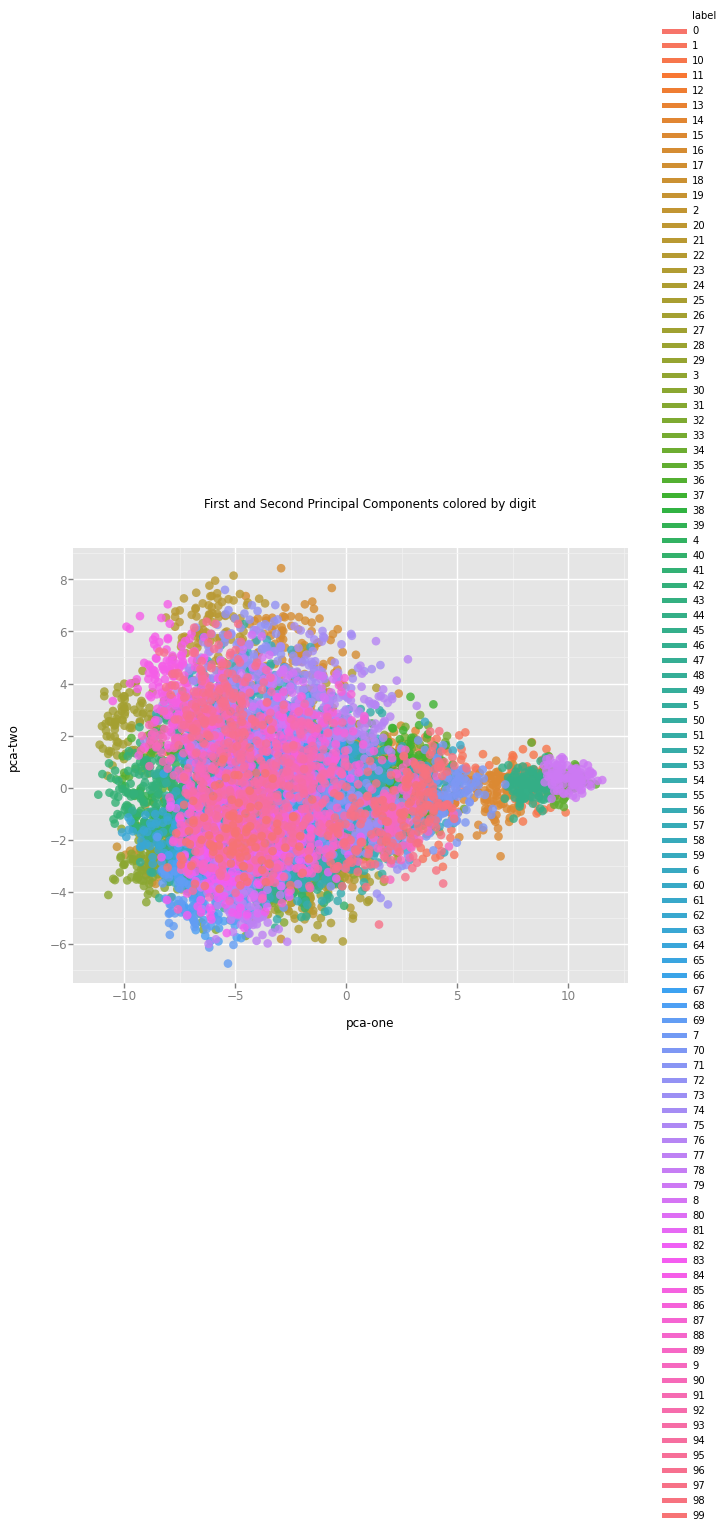

<ggplot: (8759339225037)>

In [22]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
chart = ggplot(df.loc[list_index,:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")

chart

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9900 samples in 0.163s...
[t-SNE] Computed neighbors for 9900 samples in 35.221s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9900
[t-SNE] Computed conditional probabilities for sample 2000 / 9900
[t-SNE] Computed conditional probabilities for sample 3000 / 9900
[t-SNE] Computed conditional probabilities for sample 4000 / 9900
[t-SNE] Computed conditional probabilities for sample 5000 / 9900
[t-SNE] Computed conditional probabilities for sample 6000 / 9900
[t-SNE] Computed conditional probabilities for sample 7000 / 9900
[t-SNE] Computed conditional probabilities for sample 8000 / 9900
[t-SNE] Computed conditional probabilities for sample 9000 / 9900
[t-SNE] Computed conditional probabilities for sample 9900 / 9900
[t-SNE] Mean sigma: 2.377827
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.990448


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

[t-SNE] KL divergence after 300 iterations: 2.906866
t-SNE done! Time elapsed: 71.27168893814087 seconds


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

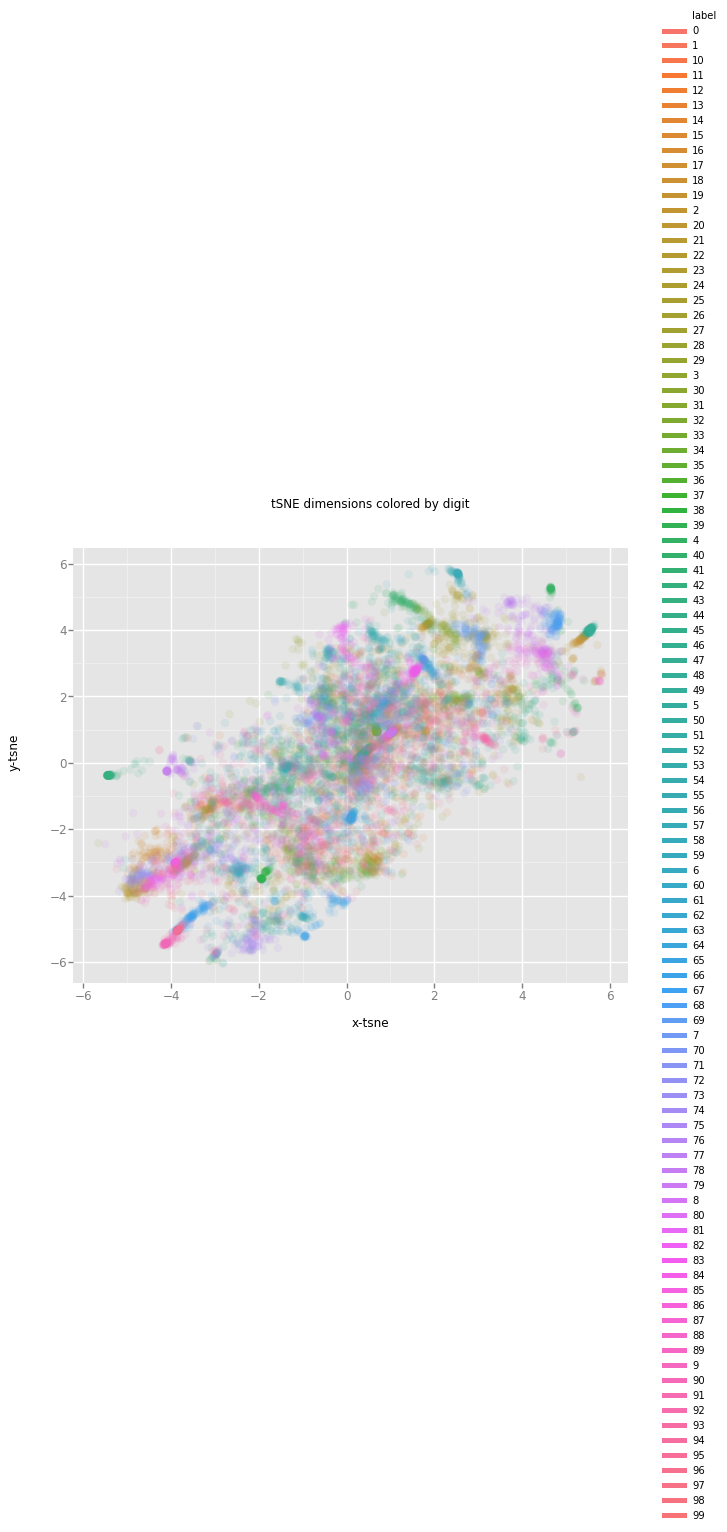

<ggplot: (8759342228601)>

In [23]:
#VISUALIZER GENE IN KMEANS WITH TSNE
n_sne = 10000

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
# tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)
tsne_results = tsne.fit_transform(df.loc[list_index,feat_cols].values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
#df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne = df.loc[list_index,:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

Cumulative explained variation for 50 principal components: 0.8162412643432617
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9900 samples in 0.079s...
[t-SNE] Computed neighbors for 9900 samples in 8.901s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9900
[t-SNE] Computed conditional probabilities for sample 2000 / 9900
[t-SNE] Computed conditional probabilities for sample 3000 / 9900
[t-SNE] Computed conditional probabilities for sample 4000 / 9900
[t-SNE] Computed conditional probabilities for sample 5000 / 9900
[t-SNE] Computed conditional probabilities for sample 6000 / 9900
[t-SNE] Computed conditional probabilities for sample 7000 / 9900
[t-SNE] Computed conditional probabilities for sample 8000 / 9900
[t-SNE] Computed conditional probabilities for sample 9000 / 9900
[t-SNE] Computed conditional probabilities for sample 9900 / 9900
[t-SNE] Mean sigma: 2.085436
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.931198


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

[t-SNE] KL divergence after 300 iterations: 2.789307
t-SNE done! Time elapsed: 46.67032051086426 seconds


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

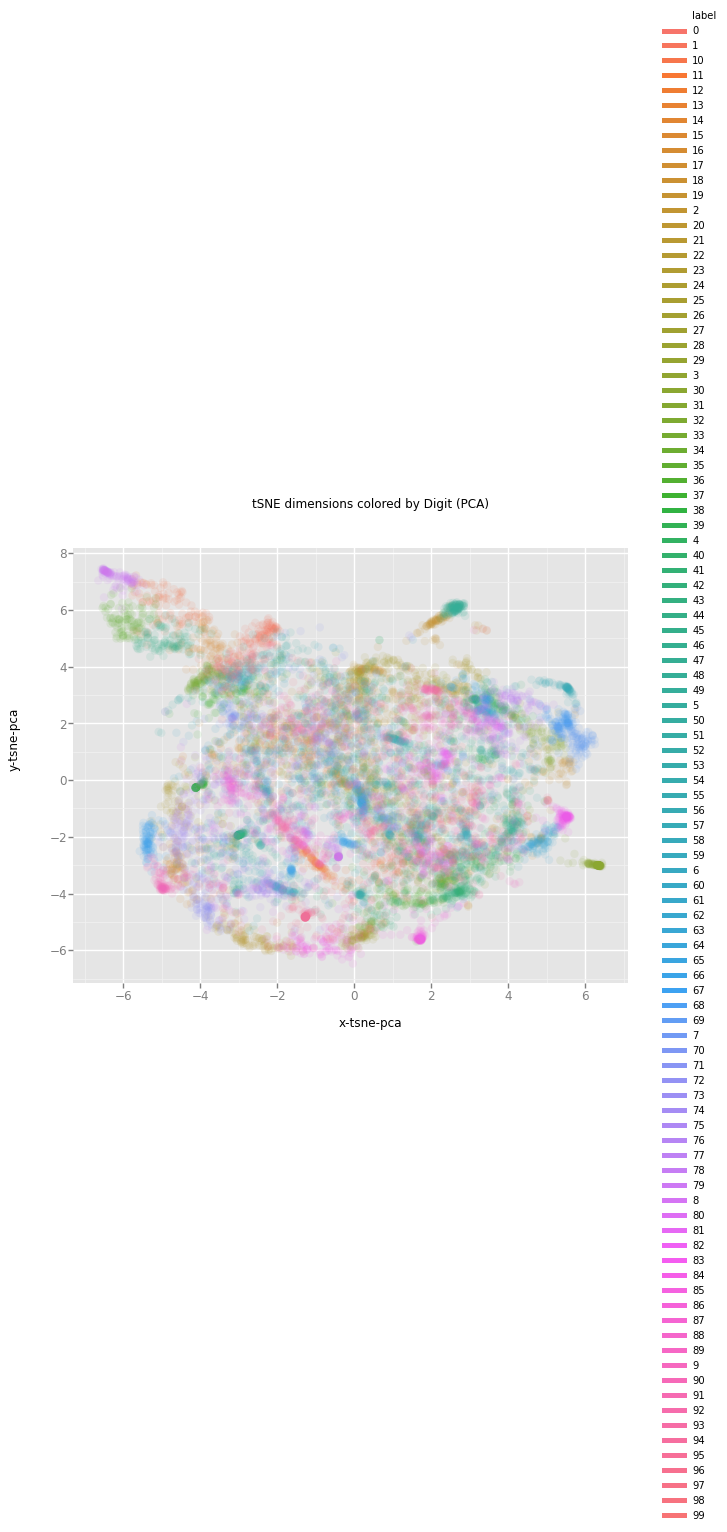

<ggplot: (8759342362461)>

In [24]:
#VISUALIZER GENE IN KMEANS PCA + TSNE
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
n_sne = 6000
time_start = time.time()

#x = rndperm[:n_sne]
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
#tsne_pca_results = tsne.fit_transform(pca_result_50[x])
tsne_pca_results = tsne.fit_transform(pca_result_50[list_index])

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = None
#df_tsne = df.loc[x,:].copy()
df_tsne = df.loc[list_index,:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot(df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")
chart